## 0. 문제 설정

### (1) 수소, 헬륨, 금속의 무게비를 70, 28, 2%로 가정한다 갯수비는 1, 28/4/70=0.1, 2/20/70=1/700 이 된다.  
### (2) 금속의 질량을 편의상 20 amu로

### (3)  Bohm-Vitense Table 12.3에 표기된 값을 따라 수소(log10(12)), 헬륨 (11), 산소(8.8), 탄소(8.5)

### (4) Gray appendixD 
### 탄소 이온화 에너지, 분배함수
### weight 12.011
### ionization potential
### I1 = 11.260, I2 = 24.383, I3 = 47.888
### partition functions, log u(T)

|theta|0.2|0.4|0.6|0.8|1.0|1.2|1.4|1.6|1.8|2.0|log g0|
|---|---|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|C  |1.163|1.037|0.994|0.975|0.964|0.958|0.954|0.951|0.950|0.948|0.954|
|C+ |0.853|0.782|0.775|0.774|0.773|0.772|0.771|0.770|0.769|0.767|0.778|
|C++|0.143|0.010|0.000|0.000|0.000|0.000|0.000|0.000|0.000|0.000|0.000|


## 1. 숙제 3 코드를 활용하여 연속흡수계수와 스펙트럼 계산하기

In [353]:
#import necessary module
import numpy as np
from scipy.interpolate import interp1d
from scipy import integrate

import matplotlib.pyplot as plt
import scipy as scipy

### (1) calculate geometrical depth

In [84]:
e = 4.8024e-10
ev=4.8e-10
h=6.626e-27
k=1.38e-16
c=3.e10
me=9.105e-28
mh=1.66e-24

teff=5500.
grav=1.e4

rhox,temp,pg,ne=np.loadtxt('Kurucz.dat',unpack=True,skiprows=5,usecols=[0,1,2,3])


theta=5040./temp
pe=ne*k*temp

#degree of ionization of H, C
theta_t= [0.2,  0.4,  0.6,  0.8,  1.0,  1.2,  1.4,  1.6,  1.8,  2.0  ]
#Hydrogen
h0u_t=   [0.368, 0.303, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301]
#Carbon
c0u_t=   [1.163, 1.037, 0.994, 0.975, 0.964, 0.958, 0.954, 0.951, 0.950, 0.948]
cpu_t=   [0.853, 0.782, 0.775, 0.774, 0.773, 0.772, 0.771, 0.770, 0.769, 0.767]
cppu_t=  [0.143, 0.010, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


h0uint = interp1d(theta_t, h0u_t, kind = 'slinear')
h0u = h0uint(theta)
h0u=np.power(10, h0u)

c0uint = interp1d(theta_t, c0u_t, kind = 'slinear')
c0u = c0uint(theta)
c0u=np.power(10, c0u)

cpuint = interp1d(theta_t, cpu_t, kind = 'slinear')
cpu = cpuint(theta)
cpu=np.power(10, cpu)

cppuint = interp1d(theta_t, cppu_t, kind = 'slinear')
cppu = cpuint(theta)
cppu=np.power(10, cppu)


#saha equation - hydrogen
hph0=-np.log10(h0u)+np.log10(2)+2.5*np.log10(temp) -13.6*theta-np.log10(pe)-0.48
h0hm=+np.log10(h0u)+np.log10(2)+2.5*np.log10(temp)-0.754*theta-np.log10(pe)-0.48

hph0=np.power(10,hph0)
h0hm=np.power(10,h0hm)

#saha equation - carbon
cpc0 = np.log10(cpu)-np.log10(c0u) + np.log10(2)+2.5*np.log10(temp) -11.260*theta-np.log10(pe)-0.48
cppcp = np.log10(cppu)-np.log10(cpu) + np.log10(2)+2.5*np.log10(temp) -24.388*theta-np.log10(pe)-0.48

cpc0 = np.power(10,cpc0)
cppcp = np.power(10, cppcp)

# calculate density ---- actually little ionization
nh=(pg/k/temp-ne)/(1.+0.1+2./70./20.)
rho=mh*nh*(1.+4*0.1+20.*(2./20./70.))

# count #
nh0=nh/(1./h0hm+1.+hph0)
nhm=1./h0hm*nh0
nhp=hph0*nh0

nc0 = nh0 * 10**(-3.5)
ncp = cpc0 * nc0
ncpp = cppcp * ncp

# geometrical depth
z=np.zeros(64)
for i in range(1,64):
    z[i]=z[i-1]+2.*(rhox[i]-rhox[i-1])/(rho[i-1]+rho[i])/1.e5   # in kilometers


In [33]:
#number of carbon in 3p 3d state
nc3_1 = nc0 * 10**(-1.31)/10**(0.954) * 10**(-8.65 * theta)
nc3_2 = nc0 * 10**(-1.67)/10**(0.954) * 10**(-8.65 * theta)
nc3_3 = nc0 * 10**(-1.)/10**(0.954) * 10**(-8.64 * theta)
c_nums = [nc3_1, nc3_2, nc3_3]

In [151]:
#carbon energy
E_i = [8.65, 8.65, 8.64] # [eV]
E_j = [4.1357e-15*3e8/(6013.17e-10) +E_i[0], 4.1357e-15*3e8/(6013.21e-10)+E_i[1],4.1357e-15*3e8/(6014.83e-10)+E_i[2]]
E_ion = 11.260

## (2) continuous absorption coefficient
### (2)-1 Hydrogen bound-free absorption coefficient

In [9]:
quan_num=np.arange(5)+1

ex_ener=13.6*(1.-1./np.square(quan_num))

freq_ion=13.6/np.square(quan_num)*1.6e-12/h
abs_cross=64.*np.pi**4*me*ev**10/3./np.sqrt(3)/c/h**6/quan_num**5

def k_H_bf(depth_index, lam):
    
#     freq =  [c/x/1.e-8 for x in lam]
    
#     freq1 = c/931/1.e-8
#     freq2 = c/3654/1.e-8
#     freq3 = c/8221/1.e-8
#     freq4 = c/14616/1.e-8
#     freq5 = c/23275/1.e-8

    freq =  [c/x/1.e-8 for x in lam]
    
    freq1 = c/931/1.e-8
    freq2 = c/3654/1.e-8
    freq3 = c/8221/1.e-8
    freq4 = c/14616/1.e-8
    freq5 = c/23275/1.e-8
    
    abs_coef_0 = [abs_cross[0]*2.*1.*np.exp(-0.)/h0u[depth_index]/x**3 *nh0[depth_index] if freq1 < x else 0 for x in freq]

    abs_coef_1 = [abs_cross[1]*2.*4.*np.exp(-ex_ener[1]*1.16e4/temp[depth_index])/h0u[depth_index]/x**3 *nh0[depth_index]
                  if freq2 < x else 0 for x in freq]

    abs_coef_2 = [abs_cross[2]*2.*9.*np.exp(-ex_ener[2]*1.16e4/temp[depth_index])/h0u[depth_index]/x**3 *nh0[depth_index] 
                if freq3 < x else 0 for x in freq]
    
    abs_coef_3 = [abs_cross[3]*2.*16.*np.exp(-ex_ener[3]*1.16e4/temp[depth_index])/h0u[depth_index]/x**3 *nh0[depth_index]
                if freq4 < x else 0 for x in freq]
    
    abs_coef_4 = [abs_cross[4]*2.*25.*np.exp(-ex_ener[4]*1.16e4/temp[depth_index])/h0u[depth_index]/x**3 *nh0[depth_index]
                 if freq5 < x else 0 for x in freq]
   
    abs_coef_h_bf = [x+y+z+w+i for x,y,z,w,i in zip(abs_coef_0, abs_coef_1, abs_coef_2, abs_coef_3, abs_coef_4)]
    
    return abs_coef_h_bf
    
# abs_coef_h_bf_log = np.log10(abs_coef_h_bf)

In [12]:
wave = np.arange(1, 16000, 1)

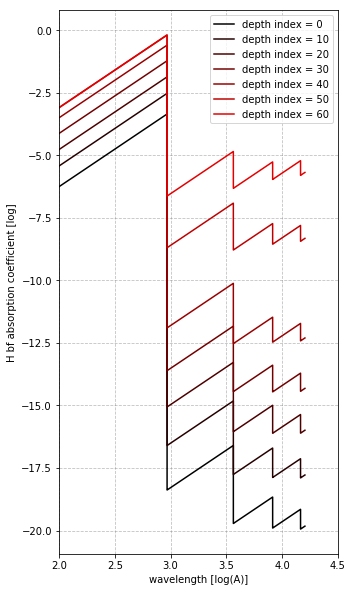

In [13]:
fig, ax = plt.subplots(figsize=(5,10))
ax.set_xlim([2,4.5])
ax.set_xlabel('wavelength [log(A)]')
ax.set_ylabel('H bf absorption coefficient [log]')
ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')

for i in np.arange(0,63, 10):
    ax.plot(np.log10(wave), np.log10(k_H_bf(i, wave)), color = [0.015*i,0,0], label = f'depth index = {i}')

ax.legend()

### (2)-2 Hydrogen free-free absorption coefficient

In [14]:
# H f-f absorption coefficient

def k_H_ff(depth_index, lam):
    abs_coef_h_ff=1.0449e-26*0.43429*np.power(10,-13.6*theta[depth_index])/2./theta[depth_index]/13.6*(lam/1.e8)**3*1.e24*nh0[depth_index]
    return abs_coef_h_ff

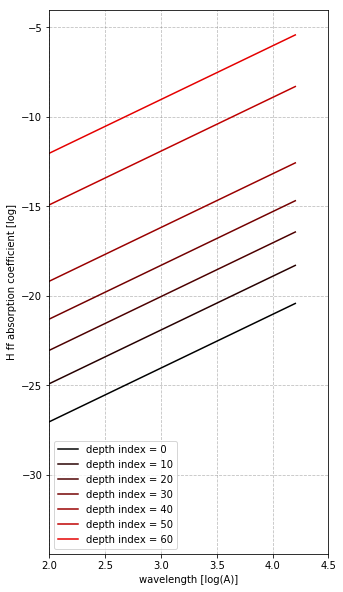

In [15]:
fig, ax = plt.subplots(figsize=(5,10))
ax.set_xlim([2,4.5])
ax.set_xlabel('wavelength [log(A)]')
ax.set_ylabel('H ff absorption coefficient [log]')

ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
for i in np.arange(0,63, 10):
    ax.plot(np.log10(wave), np.log10(k_H_ff(i, wave)), color = [0.015*i,0,0], label = f'depth index = {i}')
ax.legend()

### (2)-3 H- bound-free absorption coefficient

In [21]:
# H- b-f absorption coefficient
acoef0=1.99654
acoef1=-1.18267e-5
acoef2=2.64243e-6
acoef3=-4.40524e-10
acoef4=3.23992e-14
acoef5=-1.39568e-18
acoef6=2.78701e-23

def k_Hm_bf(depth_index, lam):
    wav=lam/1.e8
    freq =  [c/x/1.e-8 for x in lam]
    abs_coef_hm_bf=(acoef0+acoef1*wav*1.e8 +acoef2*wav**2*1.e16+acoef3*wav**3*1.e24 \
                        +acoef4*wav**4*1.e32+acoef5*wav**5*1.e40+acoef6*wav**6*1.e48)*1.e-18 \
                        *4.158e-10*pe[depth_index]*theta[depth_index]**2.5*np.power(10,0.754*theta[depth_index])\
                        *nh0[depth_index]*(1-np.exp(-h*freq[depth_index]/k/temp[depth_index]))\
    
    return abs_coef_hm_bf

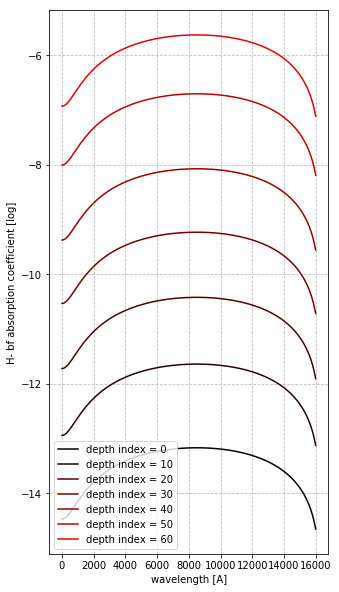

In [22]:
fig, ax = plt.subplots(figsize=(5,10))
ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('wavelength [A]')
ax.set_ylabel('H- bf absorption coefficient [log]')

for i in np.arange(0,63, 10):
    ax.plot(wave, np.log10(k_Hm_bf(i, wave)), color = [0.015*i,0,0], label = f'depth index = {i}')
ax.legend()

### (2)-4 H- free-free absorption coefficient

In [25]:
def k_Hm_ff(depth_index, lam):
    f0=-2.2763-1.685*np.log10(lam)+0.76661*(np.log10(lam))**2-0.053346*(np.log10(lam))**3
    f1=15.2827-9.2846*np.log10(lam)+1.99381*(np.log10(lam))**2-0.142631*(np.log10(lam))**3
    f2=-197.789+190.266*np.log10(lam)-67.9775*(np.log10(lam))**2+10.6913*(np.log10(lam))**3-0.62515*(np.log10(lam))**4
    
    abs_coef_hm_ff=1.e-26*pe[depth_index]*np.power(10,f0+f1*np.log10(theta[depth_index])+f2*(np.log10(theta[depth_index]))**2)*nh0[depth_index]

    return abs_coef_hm_ff

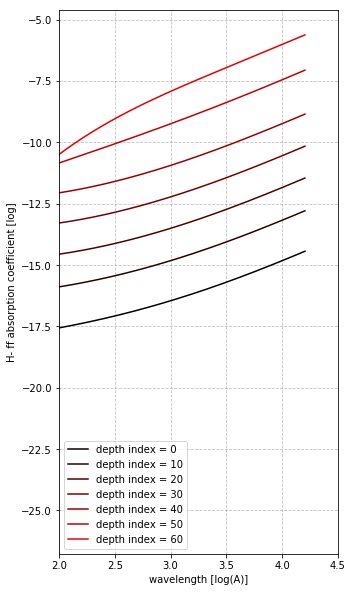

In [26]:
fig, ax = plt.subplots(figsize=(5,10))
ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('wavelength [log(A)]')
ax.set_ylabel('H- ff absorption coefficient [log]')
ax.set_xlim(2,4.5)
for i in np.arange(0,63, 10):
    ax.plot(np.log10(wave), np.log10(k_Hm_ff(i, wave)), color = [0.015*i,0,0], label = f'depth index = {i}')
ax.legend()

## (3) line absorption coefficient
### (3)-1 Lorentz profile: natural broadening, pressure broadening

In [312]:
# natural, stark, van: 0/1
def lorentz_profile(depth_index, lam, lam_0, natural, stark, van, c_num):
    
#     lam0 = lam_0*10**(-8)
#     wave = lam * 10**(-8)
    lam0 = lam_0
    wave = lam
    
    natural_gam = 2 * e**2 * (2*np.pi*c / lam0)**2 / 3 /me / c**3
    stark_gam = 10e-8 * (13.6 * 1**2 / (E_ion - E_j[c_num]))**(2.5) *ne[depth_index]

    v = (8/np.pi*(1/6/mh + 1/mh)*k*temp[depth_index])**(1/2)
    van_gam = 17 * (1.61 * 10**(-33) * (13.6*1)**2 * ((E_ion - E_j[c_num])**(-2) - (E_ion - E_i[c_num]**(-2))))**(0.4) * v**(0.6) *nh[depth_index] 

    gamma = natural*natural_gam +  stark*stark_gam + van*van_gam
    
    const = 2 * np.pi**2 * e**2 / me /c
    
    profile = const * gamma/np.pi/2/((2*np.pi*c/wave - 2*np.pi*c/lam0)**2 + (gamma/2)**2)* c_nums[c_num][depth_index]
    
    return profile

### natural broadening만 고려했을 때

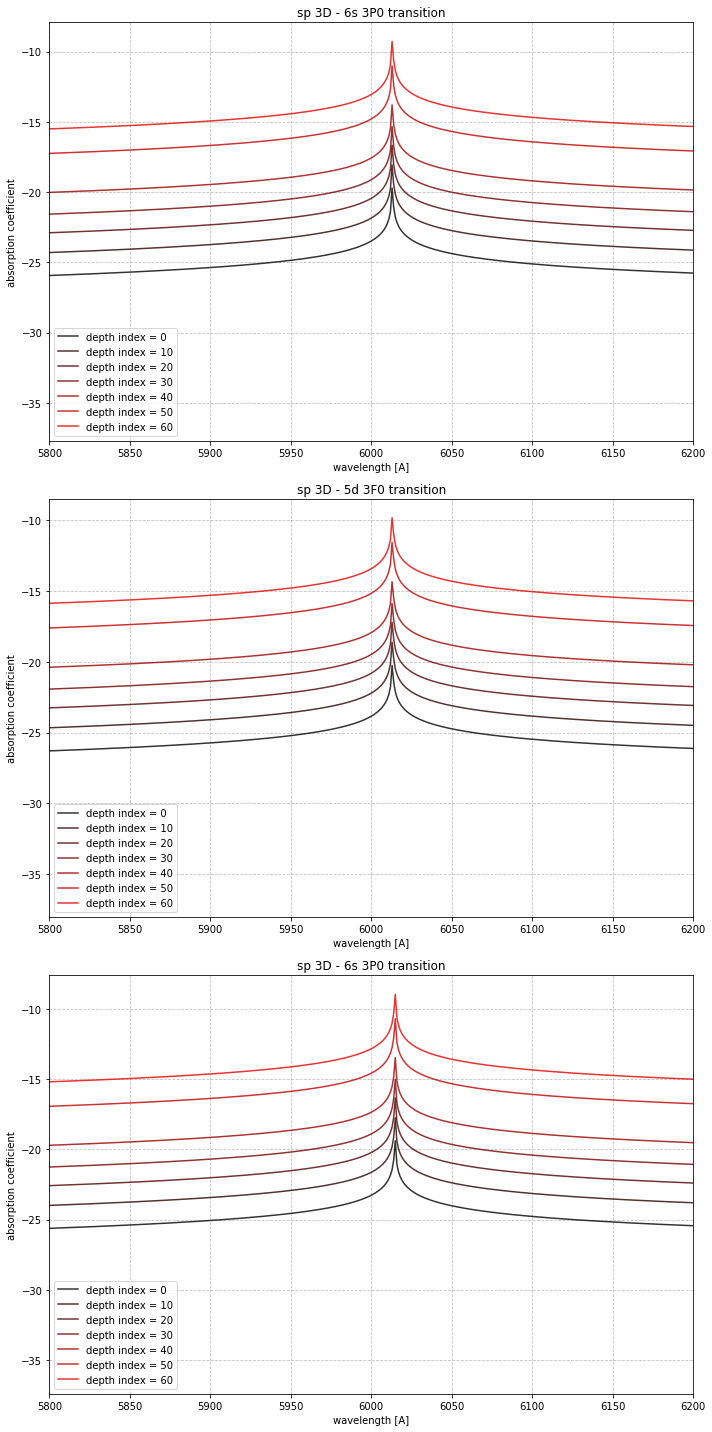

In [313]:
wave = np.arange(1,16000)

fig, axs = plt.subplots(3,figsize=(10,20))

for i in range(3):
    axs[i].set_xlim([5800,6200])
    axs[i].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
    axs[i].set_xlabel('wavelength [A]')
    axs[i].set_ylabel('absorption coefficient')
    
axs[0].set_title('sp 3D - 6s 3P0 transition')
axs[1].set_title('sp 3D - 5d 3F0 transition')
axs[2].set_title('sp 3D - 6s 3P0 transition')

for i in np.arange(0,63, 10):
    axs[0].plot(wave,np.log10(lorentz_profile(i, wave, 6013.17, 1,0,0, 0)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    axs[1].plot(wave, np.log10(lorentz_profile(i, wave, 6013.21, 1,0,0, 1)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    axs[2].plot(wave, np.log10(lorentz_profile(i, wave, 6014.83, 1,0,0, 2)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()

## pressure broadening에 의한 효과도 포함할 때

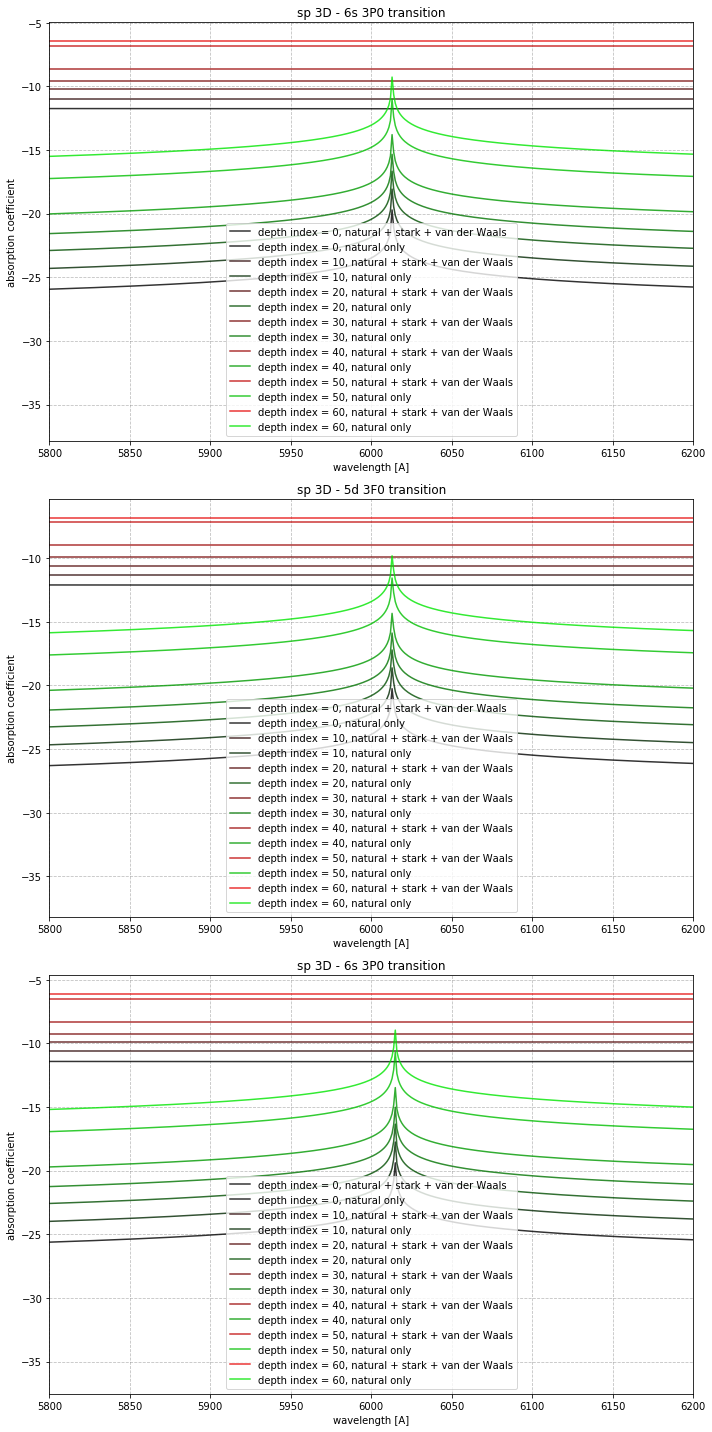

In [314]:
wave = np.arange(1,16000)

fig, axs = plt.subplots(3,figsize=(10,20))

for i in range(3):
    axs[i].set_xlim([5800,6200])
    axs[i].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
    axs[i].set_xlabel('wavelength [A]')
    axs[i].set_ylabel('absorption coefficient')
    
axs[0].set_title('sp 3D - 6s 3P0 transition')
axs[1].set_title('sp 3D - 5d 3F0 transition')
axs[2].set_title('sp 3D - 6s 3P0 transition')

for i in np.arange(0,63, 10):
    axs[0].plot(wave,np.log10(lorentz_profile(i, wave, 6013.17, 1,1,1, 0)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}, natural + stark + van der Waals')
    axs[1].plot(wave, np.log10(lorentz_profile(i, wave, 6013.21, 1,1,1, 1)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}, natural + stark + van der Waals')
    axs[2].plot(wave, np.log10(lorentz_profile(i, wave, 6014.83, 1,1,1, 2)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}, natural + stark + van der Waals')
    
    axs[0].plot(wave,np.log10(lorentz_profile(i, wave, 6013.17, 1,0,0, 0)), color = [0,0.015*i,0],alpha = 0.8,label = f'depth index = {i}, natural only')
    axs[1].plot(wave, np.log10(lorentz_profile(i, wave, 6013.21, 1,0,0, 1)), color = [0,0.015*i,0],alpha = 0.8,label = f'depth index = {i}, natural only')
    axs[2].plot(wave, np.log10(lorentz_profile(i, wave, 6014.83, 1,0,0, 2)), color = [0,0.015*i,0],alpha = 0.8,label = f'depth index = {i}, natural only')

axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()

### natural broadening만 고려했을 때 매우 sharp한 개형, pressure damping을 고려하면 무시할 만하다.

### (3)-2  doppler broadening

In [315]:
def doppler_profile(depth_index, lam,lam_0, c_num, v_turb):
#     lam0 = lam_0*10**(-8)
#     wave = lam * 10**(-8)
    
    lam0 = lam_0
    wave = lam
    
    vel_th = (2*k*temp[depth_index]/me)**(1/2)
    lam_d = wave * (vel_th**2 + v_turb**2)**(1/2)/c
    const = np.pi**(1/2) * e**2 /me/c**2
    
    profile = const * wave**2 / lam_d * np.exp(-((wave - lam0)/lam_d)**2) * c_nums[c_num][depth_index] 
    
    return profile
    

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


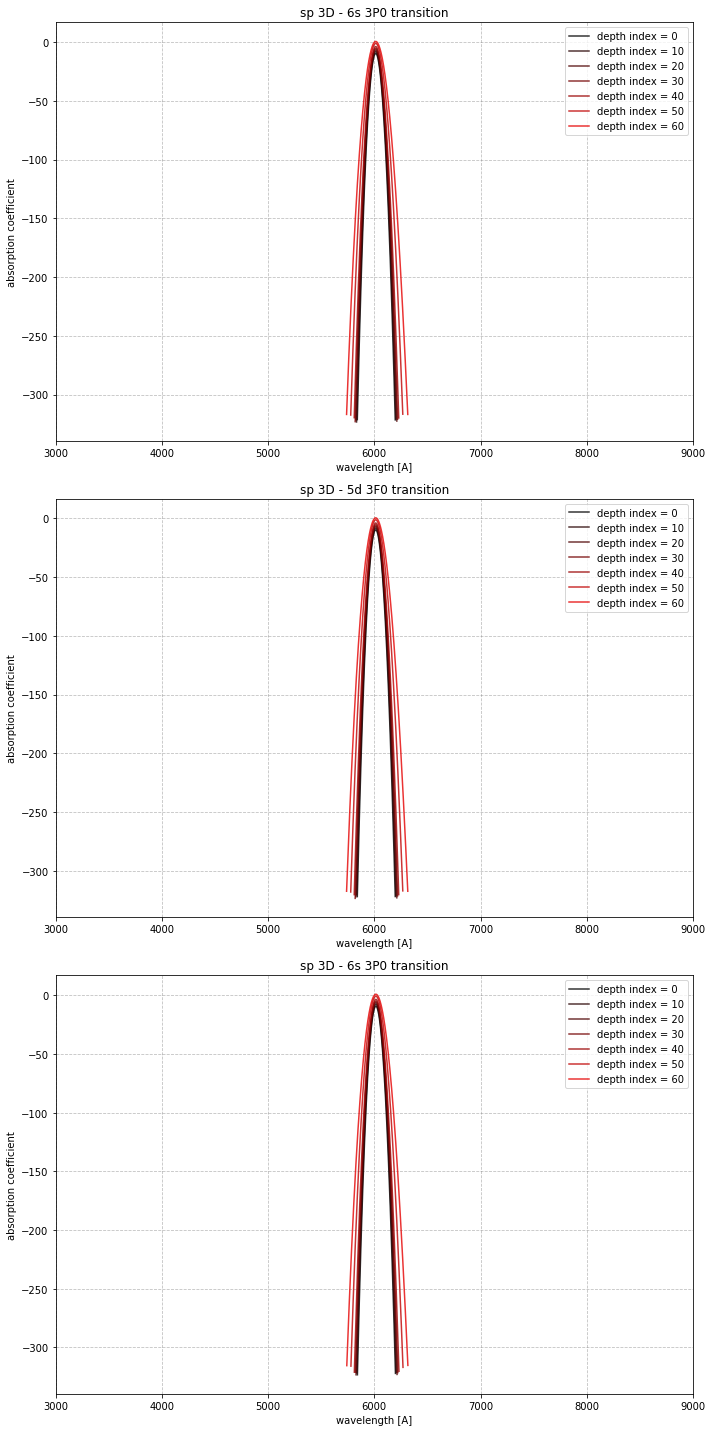

In [316]:
wave = np.arange(1,16000)

fig, axs = plt.subplots(3,figsize=(10,20))

for i in range(3):
    axs[i].set_xlim([3000,9000])
    axs[i].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
    axs[i].set_xlabel('wavelength [A]')
    axs[i].set_ylabel('absorption coefficient')
    
axs[0].set_title('sp 3D - 6s 3P0 transition')
axs[1].set_title('sp 3D - 5d 3F0 transition')
axs[2].set_title('sp 3D - 6s 3P0 transition')

for i in np.arange(0,63, 10):
    axs[0].plot(wave,np.log10(doppler_profile(i, wave, 6013.17, 0, 150000)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    axs[1].plot(wave, np.log10(doppler_profile(i, wave, 6013.21, 1, 150000)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    axs[2].plot(wave, np.log10(doppler_profile(i, wave, 6014.83, 2, 150000)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()


### (4) total absoprtion coefficient = continuous + line

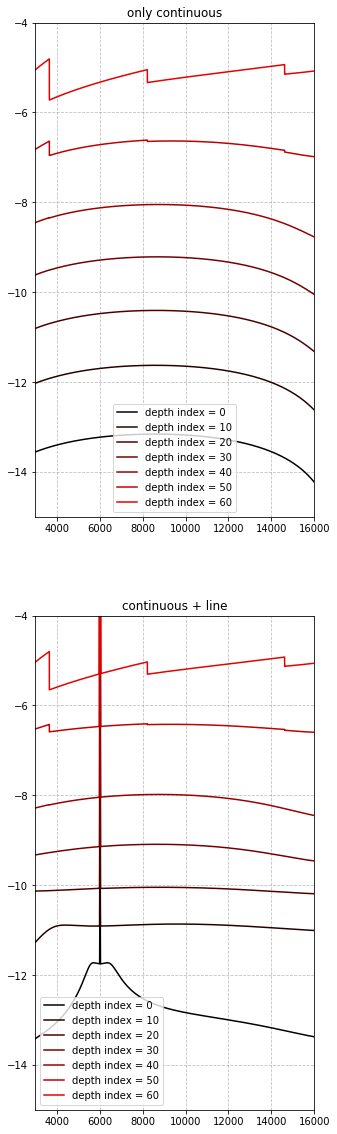

In [317]:
#total absorption coefficients
wave = np.arange(1,16000)

fig, axs = plt.subplots(2,figsize=(5,20))

for i in range(2):
    axs[i].set_xlim([3000,16000])
    axs[i].set_ylim([-15,-4])
    axs[i].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')

axs[0].set_title('only continuous')
axs[1].set_title('continuous + line')

for i in np.arange(0,63, 10):
    total_k = k_H_bf(i, wave)+k_H_ff(i, wave)+k_Hm_bf(i, wave)+k_Hm_ff(i, wave)
    axs[0].plot(wave, np.log10(total_k), color = [0.015*i,0,0], label = f'depth index = {i}')
    
    total_k2 = total_k + lorentz_profile(i, wave, 6013.17, 1,1,1, 0) + doppler_profile(i, wave, 6013.17, 0, 150000)
    axs[1].plot(wave, np.log10(total_k2), color = [0.015*i,0,0], label = f'depth index = {i}')

axs[0].legend()
axs[1].legend()


### transition 이 일어난 파장대에 흡수선이 새로 추가된 것을 확인할 수 있다.

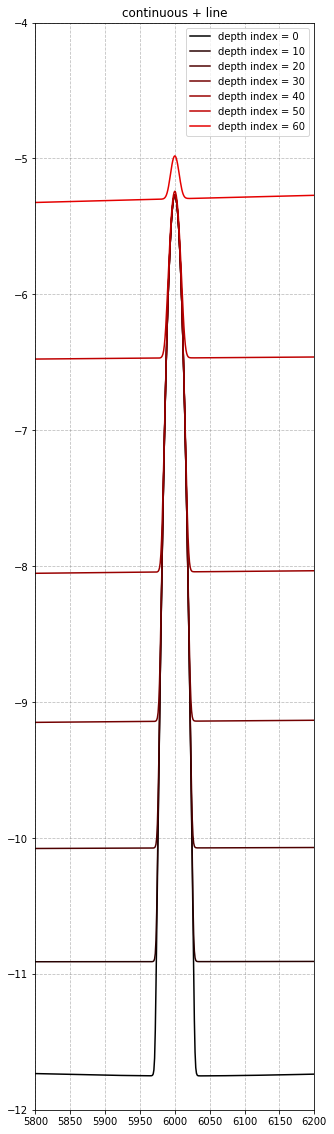

In [360]:
wave = np.arange(1,16000)

fig, axs = plt.subplots(figsize=(5,20))

axs.set_xlim([5800,6200])
axs.set_ylim([-12,-4])
axs.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
axs.set_title('continuous + line')

for i in np.arange(0,63, 10):
    total_k = k_H_bf(i, wave)+k_H_ff(i, wave)+k_Hm_bf(i, wave)+k_Hm_ff(i, wave)
    total_k2 = total_k + lorentz_profile(i, wave, 6013.17, 1,1,1, 0) + doppler_profile(30, wave, 6000, 0, 150000)
    axs.plot(wave, np.log10(total_k2), color = [0.015*i,0,0], label = f'depth index = {i}')

axs.legend()


## 2. 선 중심과 선 외곽에서 깊이의 함수로 optical depth 구하기

In [319]:
#return optical depth as a function of depth
def cal_tau(lam):
    tau_0 = [1.e-10] * len(lam)
    
    #optical depth for a given wavelength as a function of geometrical depth
    tau = []
    tau.append(tau_0)
        
    for i in range(1,64):
        
        con_k_i = k_H_bf(i, lam)+k_H_ff(i, lam)+k_Hm_bf(i, lam)+k_Hm_ff(i, lam)
        line_k_i = lorentz_profile(i, lam, 6013.17, 1,1,1, 0) + doppler_profile(i, lam, 6013.17, 0, 150000)
        
        #len(wavelength)
        total_k_i = con_k_i + line_k_i

        con_k_i2 = k_H_bf(i-1, lam)+k_H_ff(i-1, lam)+k_Hm_bf(i-1, lam)+k_Hm_ff(i-1, lam)
        line_k_i2 = lorentz_profile(i-1, lam, 6013.17, 1,1,1, 0) + doppler_profile(i-1, lam, 6013.17, 0, 150000)
        
        #len(wavelength)
        total_k_i2 = con_k_i2 + line_k_i2
        
        new_tau = tau[i-1] + (total_k_i+total_k_i2)/2 * (z[i] - z[i-1]) * 1.e5
        tau.append(new_tau)
        
    return tau

In [408]:
optical_depth = cal_tau(wave)

In [407]:
wave = np.arange(1, 16001)
wave

array([    1,     2,     3, ..., 15998, 15999, 16000])

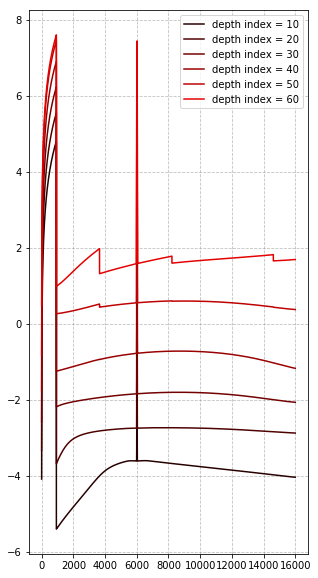

In [359]:
fig, ax = plt.subplots(figsize=(5,10))
# ax.set_xlim([2,4.5])
# ax.set_xlabel('wavelength [log(A)]')
# ax.set_ylabel('H ff absorption coefficient [log]')

ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
for i in np.arange(10,63, 10):
    ax.plot(wave, np.log10(optical_depth[i]), color = [0.015*i,0,0], label = f'depth index = {i}')
ax.legend()

In [331]:
def get_od(wave_num):

    depths = []
    for i in range(0,64):
        depth = optical_depth[i][wave_num]
        depths.append(depth)
        
    return depths

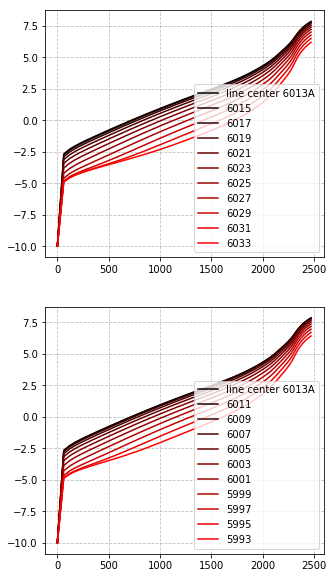

In [352]:
fig, ax = plt.subplots(2, figsize=(5,10))
# ax.set_xlim([2,4.5])
# ax.set_xlabel('wavelength [log(A)]')
# ax.set_ylabel('H ff absorption coefficient [log]')

ax[0].plot(z, np.log10(get_od(6013)), color = [0.0,0,0], label = 'line center 6013A')
ax[1].plot(z, np.log10(get_od(6013)), color = [0.0,0,0], label = 'line center 6013A')

for i in np.arange(2, 22, 2):
    ax[0].plot(z, np.log10(get_od(6013+i)), color = [0.05*i,0,0], label = f'{6013+i}')
    ax[1].plot(z, np.log10(get_od(6013-i)), color = [0.05*i,0,0], label = f'{6013-i}')


ax[0].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax[0].legend()
ax[1].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax[1].legend()

## 3. 별의 원반 중심에서 나오는 specific intensity

In [354]:
def plank_func(lam, depth_index):
    wav = lam/1.e8
#     freq = [c/x/1.e-8 for x in lam]
    freq = c/lam/1.e-8
    
    plank = 2.*h*c**2/wav**5/(np.exp(h*freq/k/temp[depth_index])-1.)
    return plank

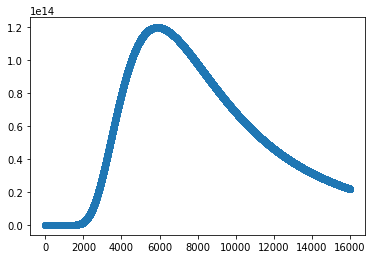

In [409]:
plt.scatter(wave, plank_func(wave, 40))

In [410]:
optical_depth[0]

[1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,
 1e-10,


In [417]:
intensities = []
wave = np.arange(1,16000)
for i in wave:
    planks = []
    ods = []
    for j in range(0, 64):
        planks.append(plank_func(i, j))
        ods.append(optical_depth[j][i])
    
    ods2 = [np.exp(-x) for x in ods]
    integrand = [x*y for x,y in zip(planks,ods2)]
    
    intensity = integrate.simps(integrand, ods)
    intensities.append(intensity)

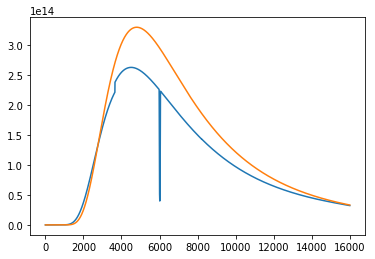

In [430]:
# len(intensities)
plt.plot(wave, intensities)
plt.plot(wave, plank_func(wave, 47))

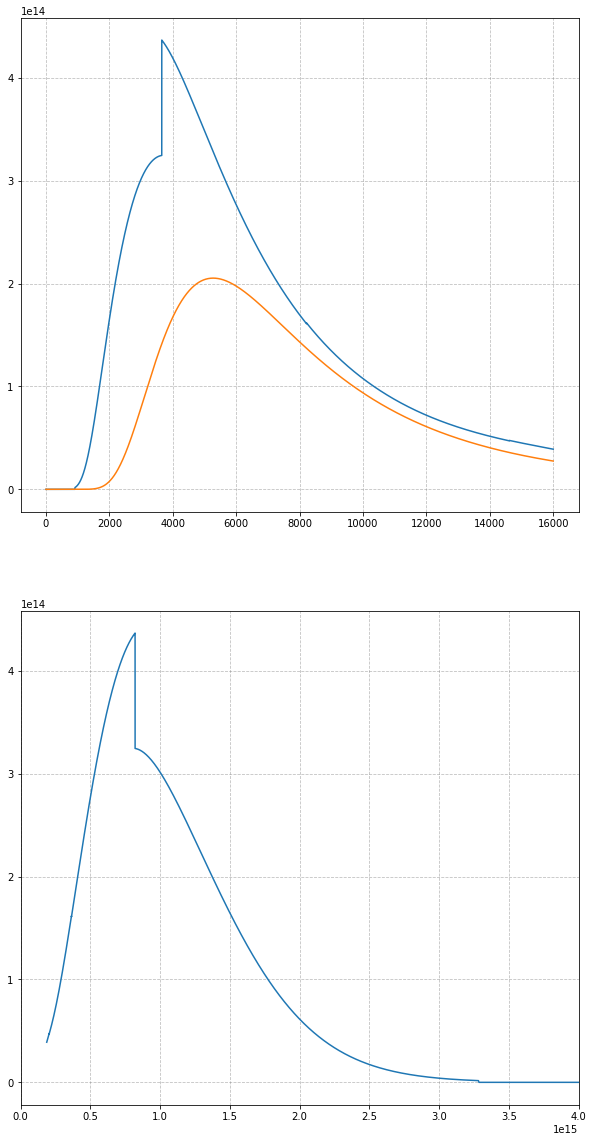

In [12]:
# integration to derive specific intensity from disk center
from scipy import integrate

intensity=np.zeros(16001)
sou=np.zeros(64)
tau_new=np.zeros(64)
tau_log_new=np.zeros(64)

plk=2.*h*c**2/wav**5/(np.exp(h*freq/k/5500.)-1.)

for i in range(16001):
    for j in range(64):
        sou[j]=2.*h*c**2/wav[i]**5/(np.exp(h*freq[i]/k/temp[j])-1)
        tau_new[j]=tau[j,i]
        tau_log_new[j]=tau_log[j,i]
#    intensity[i]=integrate.simps(sou*np.exp(-tau_new),tau_new)
    intensity[i]=integrate.simps(sou*np.exp(-tau_new)*tau_new,tau_log_new)*2.3
    
fig, axs = plt.subplots(2,figsize=(10,20))
#axs[0].set_xlim([3000,16000])
#axs[0].set_ylim([-8,4])
axs[0].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
axs[0].plot(wave,intensity)
axs[0].plot(wave,plk)
axs[1].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
axs[1].set_xlim([0,4.e15])
axs[1].plot(freq,intensity)
plt.show()

## 4. 탄소 함량 변화에 따른 등가폭 변화 -> 성장곡선

## 5. 미시난류 변화에 따른 변화